In [1]:
# ==== CELL 1: SETUP ====
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, cv2, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16
import scipy.io as sio
import random, pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

BASE = '/content/drive/MyDrive/ShanghaiTech'

TRAIN_IMG_B = f'{BASE}/part_B/train_data/images'
TRAIN_MAT_B = f'{BASE}/part_B/train_data/ground-truth'
TRAIN_DEN_B = f'{BASE}/preprocessed/train_density_B'   # will be created

TEST_IMG_B  = f'{BASE}/part_B/test_data/images'
TEST_MAT_B  = f'{BASE}/part_B/test_data/ground-truth'
TEST_DEN_B  = f'{BASE}/preprocessed/test_density_B'    # will be created

os.makedirs(TRAIN_DEN_B, exist_ok=True)
os.makedirs(TEST_DEN_B,  exist_ok=True)

print("Train images exist:", os.path.exists(TRAIN_IMG_B))
print("Train GT exist:",     os.path.exists(TRAIN_MAT_B))
print("Test images exist:",  os.path.exists(TEST_IMG_B))
print("Test GT exist:",      os.path.exists(TEST_MAT_B))


Mounted at /content/drive
Device: cuda
Train images exist: True
Train GT exist: True
Test images exist: True
Test GT exist: True


In [2]:
# ==== CELL 2: DENSITY MAP GENERATION (PART B) ====

def generate_density_B(gt_dir, img_dir, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.mat')])
    generated = 0

    for gt_file in gt_files:
        try:
            mat_path = os.path.join(gt_dir, gt_file)
            mat = sio.loadmat(mat_path)

            # points: image_info[0,0]['location'][0,0] → (N,2)
            pts = mat['image_info'][0,0]['location'][0,0]

            # GT_IMG_1.mat → IMG_1.jpg
            img_name = gt_file.replace('GT_', '').replace('.mat', '.jpg')
            img_path = os.path.join(img_dir, img_name)
            if not os.path.exists(img_path):
                continue

            img = cv2.imread(img_path)
            h, w = img.shape[:2]

            den = np.zeros((64, 64), dtype=np.float32)
            if pts.size > 0:
                for x, y in pts:
                    xs = int((x / w) * 64)
                    ys = int((y / h) * 64)
                    if 0 <= xs < 64 and 0 <= ys < 64:
                        den[ys, xs] += 1.0

                den = cv2.GaussianBlur(den, (11, 11), 0)

            out_path = os.path.join(out_dir, img_name.replace('.jpg', '.npy'))
            np.save(out_path, den)
            generated += 1
        except Exception:
            continue

    return generated

print("Generating Part B density maps...")
n_tr = generate_density_B(TRAIN_MAT_B, TRAIN_IMG_B, TRAIN_DEN_B)
n_te = generate_density_B(TEST_MAT_B,  TEST_IMG_B,  TEST_DEN_B)
print(f"Generated: {n_tr} train, {n_te} test density maps")


Generating Part B density maps...
Generated: 400 train, 316 test density maps


In [3]:
# ==== CELL 3: DATASET CLASS ====

class CrowdDatasetB(Dataset):
    def __init__(self, imgdir, dendir, augment=False):
        self.imgdir = imgdir
        self.dendir = dendir
        self.augment = augment

        self.images = sorted([f for f in os.listdir(imgdir) if f.endswith('.jpg')])
        self.dens   = sorted([f for f in os.listdir(dendir) if f.endswith('.npy')])

        self.pairs = []
        for img in self.images:
            bn = img.replace('.jpg', '')
            for d in self.dens:
                if bn in d:
                    self.pairs.append((img, d))
                    break
        print(f"Dataset at {imgdir}: {len(self.pairs)} pairs")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        imgf, denf = self.pairs[idx]

        # image
        img = cv2.imread(os.path.join(self.imgdir, imgf))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512)).astype(np.float32) / 255.0

        # density
        den = np.load(os.path.join(self.dendir, denf)).astype(np.float32)
        if den.shape != (64, 64):
            s = den.sum()
            den = cv2.resize(den, (64, 64), interpolation=cv2.INTER_AREA)
            if den.sum() > 0:
                den *= (s / den.sum())

        den *= 0.1  # scaling fix

        # augmentation
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img).copy()
            den = np.fliplr(den).copy()

        img_t = torch.from_numpy(img.copy()).permute(2, 0, 1).float()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img_t = (img_t - mean) / std

        den_t = torch.from_numpy(den.copy()).unsqueeze(0).float()
        return img_t, den_t

train_ds = CrowdDatasetB(TRAIN_IMG_B, TRAIN_DEN_B, augment=True)
test_ds  = CrowdDatasetB(TEST_IMG_B,  TEST_DEN_B,  augment=False)

BATCH_SIZE = 8
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))


Dataset at /content/drive/MyDrive/ShanghaiTech/part_B/train_data/images: 400 pairs
Dataset at /content/drive/MyDrive/ShanghaiTech/part_B/test_data/images: 316 pairs
Train batches: 50 Test batches: 79


In [4]:
# ==== CELL 4: MODEL + OPTIMIZER ====

class LightCSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights='IMAGENET1K_V1')
        # cut VGG at conv3_3 for speed
        self.backbone = nn.Sequential(*list(vgg.features.children())[:17])
        self.regressor = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 64,  3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64,  1,   1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.regressor(x)
        return x

model = LightCSRNet().to(device)
print("Model params (M):", sum(p.numel() for p in model.parameters()) / 1e6)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 76.1MB/s]


Model params (M): 2.104385


In [5]:
# ==== CELL 5: TRAINING LOOP (GPU) ====

EPOCHS = 150          # with GPU this should fit well in your time
train_losses = []
best_mae = float('inf')

print(f"Starting GPU training for {EPOCHS} epochs...")

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (imgs, dens) in enumerate(train_loader):
        imgs = imgs.to(device, non_blocking=True)
        dens = dens.to(device, non_blocking=True)

        optimizer.zero_grad()
        preds = model(imgs)

        if preds.shape[2:] != dens.shape[2:]:
            dens = F.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(preds, dens)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # validation every 2 epochs
    if epoch % 10 == 0 or epoch == EPOCHS:
        model.eval()
        mae_sum, n = 0, 0
        with torch.no_grad():
            for imgs, dens in test_loader:
                imgs = imgs.to(device, non_blocking=True)
                dens = dens.to(device, non_blocking=True)
                preds = model(imgs)
                if preds.shape[2:] != dens.shape[2:]:
                    dens = F.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)
                mae_sum += abs(preds.sum().item() - dens.sum().item())
                n += 1
        mae = mae_sum / n
        print(f"Epoch {epoch:2d}/{EPOCHS} | Loss {avg_loss:.5f} | MAE {mae:.2f}")
        if mae < best_mae:
            best_mae = mae
            torch.save(model.state_dict(), '/content/best_model_B_gpu.pth')
            print("  -> new best model saved")

print("Training finished. Best MAE:", best_mae)


Starting GPU training for 150 epochs...
Epoch 10/150 | Loss 0.00006 | MAE 24.01
  -> new best model saved
Epoch 20/150 | Loss 0.00005 | MAE 15.78
  -> new best model saved
Epoch 30/150 | Loss 0.00005 | MAE 51.62
Epoch 40/150 | Loss 0.00005 | MAE 44.49
Epoch 50/150 | Loss 0.00006 | MAE 11.27
  -> new best model saved
Epoch 60/150 | Loss 0.00006 | MAE 11.57
Epoch 70/150 | Loss 0.00006 | MAE 32.24
Epoch 80/150 | Loss 0.00006 | MAE 11.79
Epoch 90/150 | Loss 0.00006 | MAE 13.22
Epoch 100/150 | Loss 0.00006 | MAE 15.81
Epoch 110/150 | Loss 0.00006 | MAE 18.12
Epoch 120/150 | Loss 0.00007 | MAE 22.72
Epoch 130/150 | Loss 0.00007 | MAE 19.26
Epoch 140/150 | Loss 0.00007 | MAE 13.36
Epoch 150/150 | Loss 0.00007 | MAE 12.24
Training finished. Best MAE: 11.266159395628337


FINAL RESULTS – PART B (GPU)
MAE:   4.5677
RMSE:  7.1832
MAPE:  45.34%
Mean GT:   12.26
Mean Pred: 10.73


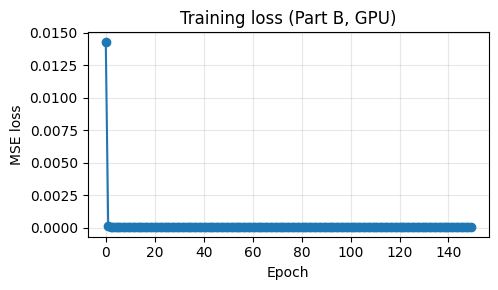

Saved: best_model_B_gpu.pth, partB_gpu_loss.png, partB_results_gpu.csv


In [6]:
# ==== CELL 6: EVALUATION & PLOTS ====

model.load_state_dict(torch.load('/content/best_model_B_gpu.pth', map_location=device))

def evaluate(model, loader, device):
    model.eval()
    mae_sum = mse_sum = 0.0
    n = 0
    preds_all, gts_all = [], []
    with torch.no_grad():
        for imgs, dens in loader:
            imgs, dens = imgs.to(device), dens.to(device)
            preds = model(imgs)
            if preds.shape[2:] != dens.shape[2:]:
                dens = F.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)
            pc = preds.sum(dim=(1,2,3)).cpu().numpy()
            gc = dens.sum(dim=(1,2,3)).cpu().numpy()
            mae_sum += np.abs(pc - gc).sum()
            mse_sum += ((pc - gc)**2).sum()
            n += len(pc)
            preds_all.extend(pc)
            gts_all.extend(gc)
    preds_all = np.array(preds_all)
    gts_all = np.array(gts_all)
    mae = mae_sum / n
    rmse = np.sqrt(mse_sum / n)
    mape = np.mean(np.abs(preds_all - gts_all) / (gts_all + 1e-5)) * 100
    return mae, rmse, mape, preds_all, gts_all

mae, rmse, mape, preds, gts = evaluate(model, test_loader, device)

print("="*60)
print("FINAL RESULTS – PART B (GPU)")
print("="*60)
print(f"MAE:   {mae:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAPE:  {mape:.2f}%")
print(f"Mean GT:   {np.mean(gts):.2f}")
print(f"Mean Pred: {np.mean(preds):.2f}")
print("="*60)

# loss curve
plt.figure(figsize=(5,3))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.title("Training loss (Part B, GPU)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/partB_gpu_loss.png', dpi=120)
plt.show()

# save results CSV
df = pd.DataFrame({
    'GT': gts,
    'Pred': preds,
    'AbsError': np.abs(preds - gts),
    'PctError': (np.abs(preds - gts) / (gts + 1e-5)) * 100
})
df.to_csv('/content/partB_results_gpu.csv', index=False)
print("Saved: best_model_B_gpu.pth, partB_gpu_loss.png, partB_results_gpu.csv")


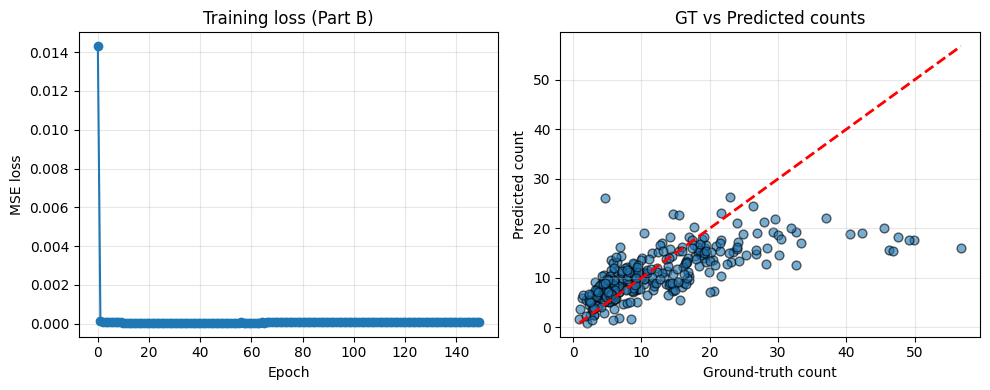

In [7]:
# ==== CELL 7: BASIC VISUALIZATIONS ====

plt.figure(figsize=(10,4))

# loss curve
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training loss (Part B)")
plt.grid(True, alpha=0.3)

# GT vs Pred
plt.subplot(1,2,2)
plt.scatter(gts, preds, alpha=0.6, s=40, edgecolors='k')
mn, mx = min(gts.min(), preds.min()), max(gts.max(), preds.max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=2)
plt.xlabel("Ground-truth count")
plt.ylabel("Predicted count")
plt.title("GT vs Predicted counts")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/partB_vis_basic.png', dpi=150, bbox_inches='tight')
plt.show()


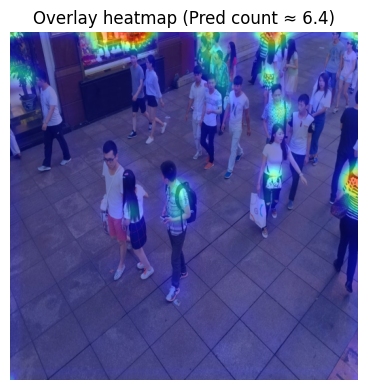

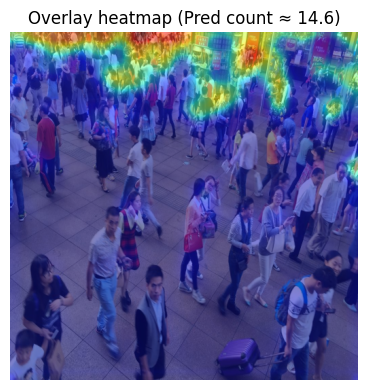

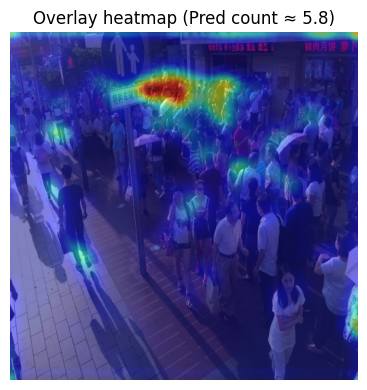

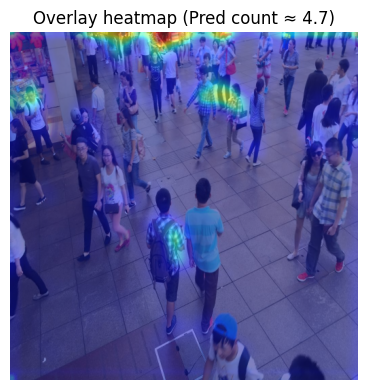

In [8]:
# ==== HEATMAP OVERLAY VISUALIZATION ====

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def show_overlay_samples(model, loader, device, num_samples=4, alpha=0.5):
    """
    Show input image with predicted density heatmap overlaid.
    """
    model.eval()
    shown = 0

    with torch.no_grad():
        for imgs, dens in loader:
            imgs = imgs.to(device)
            preds = model(imgs)

            if preds.shape[2:] != dens.shape[2:]:
                dens = F.interpolate(dens.to(device), size=preds.shape[2:], mode='bilinear', align_corners=False)

            bsz = imgs.size(0)
            for b in range(bsz):
                if shown >= num_samples:
                    return

                # de-normalize image
                img = imgs[b].cpu().permute(1,2,0).numpy()
                img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
                img = np.clip(img, 0, 1)

                # predicted density
                den_pred = preds[b,0].cpu().numpy()
                den_pred = np.maximum(den_pred, 0)

                # resize density to image size for nicer overlay
                den_resized = cv2.resize(den_pred, (img.shape[1], img.shape[0]))
                den_norm = den_resized / (den_resized.max() + 1e-8)

                plt.figure(figsize=(5,4))
                plt.imshow(img)
                plt.imshow(den_norm, cmap='jet', alpha=alpha)  # overlay
                pred_count = den_pred.sum()
                plt.title(f"Overlay heatmap (Pred count ≈ {pred_count:.1f})")
                plt.axis('off')
                plt.tight_layout()
                plt.show()

                shown += 1

# show 4 overlay examples
show_overlay_samples(model, test_loader, device, num_samples=4, alpha=0.5)


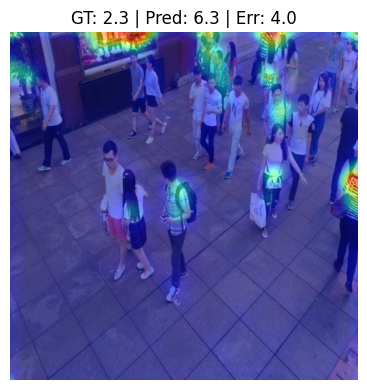

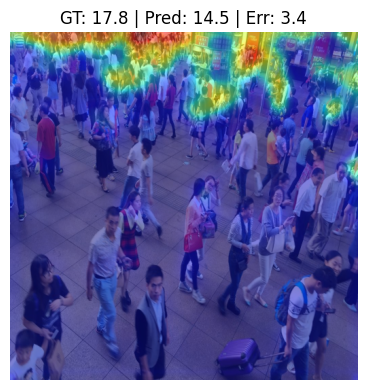

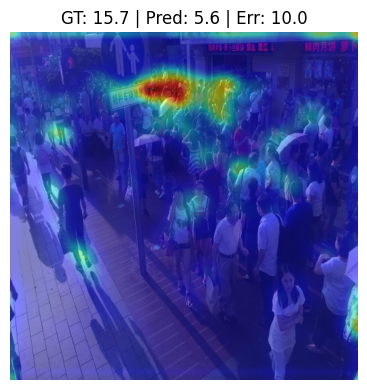

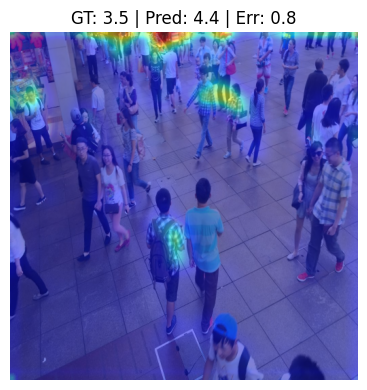

In [9]:
# ==== HEATMAP OVERLAY WITH GT & PRED COUNTS ====

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import cv2

def show_overlay_with_counts(model, loader, device, num_samples=4, alpha=0.5):
    """
    Show input image with predicted density heatmap overlaid,
    and display GT count + predicted count in the title.
    """
    model.eval()
    shown = 0

    with torch.no_grad():
        for imgs, dens in loader:
            imgs = imgs.to(device)
            dens = dens.to(device)
            preds = model(imgs)

            if preds.shape[2:] != dens.shape[2:]:
                dens = F.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)

            bsz = imgs.size(0)
            for b in range(bsz):
                if shown >= num_samples:
                    return

                # ---- de-normalize image ----
                img = imgs[b].cpu().permute(1,2,0).numpy()
                img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
                img = np.clip(img, 0, 1)

                # ---- densities ----
                gt_den  = dens[b,0].cpu().numpy()
                pr_den  = preds[b,0].cpu().numpy()

                gt_count = gt_den.sum()
                pr_count = pr_den.sum()
                err = abs(gt_count - pr_count)

                # resize predicted density to image size for overlay
                den_resized = cv2.resize(pr_den, (img.shape[1], img.shape[0]))
                den_norm = den_resized / (den_resized.max() + 1e-8)

                plt.figure(figsize=(5,4))
                plt.imshow(img)
                # overlay ONLY model’s prediction as heatmap
                plt.imshow(den_norm, cmap='jet', alpha=alpha)
                plt.title(f"GT: {gt_count:.1f} | Pred: {pr_count:.1f} | Err: {err:.1f}")
                plt.axis('off')
                plt.tight_layout()
                plt.show()

                shown += 1

# call this after evaluation
show_overlay_with_counts(model, test_loader, device, num_samples=4, alpha=0.5)
